# Severn Influence of Height Case Study

## Table of contents
[1 Compute flood events](#compute-flood-events)  
[2 Look at rainfall above gauge height](#look-at-rainfall-in-cells-above-gauge)  

In [1]:
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray

import pyextremes

import matplotlib.pyplot as plt


In [2]:
SEVERN_EASTING_RANGE = [280000, 400000]
SEVERN_NORTHING_RANGE = [260000, 360000]

SEVERN_ID_TO_NAMES = {"Abermule": 54014, "Dolwen": 54080, "Plynlimon Flume": 54022,\
                      "Bewdley": 54001}

In [18]:
PATH_TO_HADUK = "../../../HadUK_Grid/haduk_grid_1km_day/"

# Load Data
For NRFA stations, catchments, and rivers data & CEH-GEAR and HadUK-Grid rainfall data

In [4]:
## NRFA station metadata
nrfa_station_metadata = pd.read_csv('../NRFA_Stations/nrfa_stations_data.csv', index_col=0) 

## Big catchments
bewdley_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == SEVERN_ID_TO_NAMES["Bewdley"]]

## High altitude catchments
abermule_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == SEVERN_ID_TO_NAMES["Abermule"]]
dolwen_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == SEVERN_ID_TO_NAMES["Dolwen"]]
plynlimon_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == SEVERN_ID_TO_NAMES["Plynlimon Flume"]]

In [41]:
## Gauged daily flow (gdf)
## units: m^3 s^-1 (cumecs)
abermule_gdf = pd.read_csv('Catchment_Data/Abermule/54014_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
bewdley_gdf = pd.read_csv('Catchment_Data/Bewdley/54001_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
buildwas_gdf = pd.read_csv('Catchment_Data/Buildwas/54095_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
dolwen_gdf = pd.read_csv('Catchment_Data/Dolwen/54080_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
montford_gdf = pd.read_csv('Catchment_Data/Montford/54005_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
plynlimon_flume_gdf = pd.read_csv('Catchment_Data/Plynlimon Flume/54022_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])

In [42]:
haduk_severn_200803 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20080301-20080331.nc').sel(projection_x_coordinate=slice(*SEVERN_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*SEVERN_NORTHING_RANGE))
haduk_severn_200811 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20081101-20081130.nc').sel(projection_x_coordinate=slice(*SEVERN_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*SEVERN_NORTHING_RANGE))
haduk_severn_201204 = xr.open_dataset(f'{PATH_TO_HADUK}/hadukgrid_severn_1km_day_201204.nc').sel(projection_x_coordinate=slice(*SEVERN_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*SEVERN_NORTHING_RANGE))
haduk_severn_201302 = xr.open_dataset(f'{PATH_TO_HADUK}/hadukgrid_severn_1km_day_201302.nc').sel(projection_x_coordinate=slice(*SEVERN_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*SEVERN_NORTHING_RANGE))
haduk_severn_202001 = xr.open_dataset(f'{PATH_TO_HADUK}/hadukgrid_severn_1km_day_202001.nc').sel(projection_x_coordinate=slice(*SEVERN_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*SEVERN_NORTHING_RANGE))

In [43]:
bewdley_shp = gpd.read_file('Catchment_Data/Bewdley/54001/54001.shp')

abermule_shp = gpd.read_file('Catchment_Data/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('Catchment_Data/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('Catchment_Data/Plynlimon Flume/54022/54022.shp')

In [44]:
severn_hght = rioxarray.open_rasterio('Catchment_Data/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

# Compute flood events
get dates when 'floods' occured based on 95th Peaks Over Threshold

In [45]:
def compute_flood_event_dates(gdf_data, q=.95):
    q95 = gdf_data['gdf'].quantile(q)
    return pyextremes.get_extremes(gdf_data.set_index('date')['gdf'], 'POT', threshold=q95).index

In [ ]:
bewdley_flood = compute_flood_event_dates(bewdley_gdf, q=.95)
buildwas_flood = compute_flood_event_dates(buildwas_gdf, q=.95)
montford_flood = compute_flood_event_dates(montford_gdf, q=.95)

len(bewdley_flood), len(buildwas_flood), len(montford_flood)

(487, 155, 399)

In [14]:
montford_bewdley_floods = set(montford_flood).intersection(set(bewdley_flood))
severn_floods = montford_bewdley_floods.intersection(set(buildwas_flood))
print(f"Total of {len(severn_floods)} flood events co-occuring across the catchments")

Total of 25 flood events co-occuring across the catchments


In [15]:
severn_floods = sorted(list(severn_floods))
severn_floods[-5:]

[Timestamp('2008-03-17 00:00:00'),
 Timestamp('2008-11-11 00:00:00'),
 Timestamp('2012-04-30 00:00:00'),
 Timestamp('2013-02-15 00:00:00'),
 Timestamp('2020-01-15 00:00:00')]

In [16]:
## Flood events
flood200803 = severn_floods[-5]
flood200811 = severn_floods[-4]
flood201204 = severn_floods[-3]
flood201302 = severn_floods[-2]
flood202001 = severn_floods[-1]

In [17]:
flood_data_dict = { "flood200803": {"date": flood200803, "data": haduk_severn_200803},\
                    "flood200811": {"date": flood200811, "data": haduk_severn_200811},\
                    "flood201204": {"date": flood201204, "data": haduk_severn_201204},\
                    "flood201302": {"date": flood201302, "data": haduk_severn_201302},\
                    "flood202001": {"date": flood202001, "data": haduk_severn_202001}}

# Look at rainfall in cells above gauge
[Back to ToC](#table-of-contents)

In [18]:
plynlimon_station

,STATION,COUNTRY,DTM_EASTING,DTM_NORTHING,CCAR,HGHT,QALT,QASB,QASV,QB19,...,HGB-00,HGB-01,HGB-02,HGB-03,HGB-04,HGS-00,HGS-01,HGS-02,HGS-03,HGS-04
1655,54022,GB,285300,287200,8.7475,3214.0,501.0,116.0,0.43,0.265,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# # Abermule (868)
# [[890, 1283],
# [1719, 1111]]

# # Dolwen (1473)
# [[1787, 1544],
# [1739, 2081]]

# # Plynlimon (3214)
# [[3813, 4764],
# [4382, 3427]]

In [20]:
## PROBLEM: the height in NRFA data is exact, and HGHT is 1km interpolated
station_to_examine = abermule_station
print(f"Height of station = {station_to_examine['HGHT'].values[0]}.\
       xy = {station_to_examine['DTM_EASTING'].values[0], station_to_examine['DTM_NORTHING'].values[0]}")
severn_hght.sel(x=slice(station_to_examine['DTM_EASTING'].values[0]-500, station_to_examine['DTM_EASTING'].values[0]+1000),\
                        y=slice(station_to_examine['DTM_NORTHING'].values[0]-500, station_to_examine['DTM_NORTHING'].values[0]+1000)).load()

Height of station = 868.0.       xy = (np.int64(316550), np.int64(295800))


<xarray.DataArray (y: 2, x: 2)> Size: 16B
array([[ 890, 1283],
       [1719, 1111]], dtype=int32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16B 3.165e+05 3.175e+05
  * y            (y) float64 16B 2.955e+05 2.965e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        8610
    STATISTICS_MEAN:           1998.7916666667
    STATISTICS_MINIMUM:        54
    STATISTICS_STDDEV:         1329.9633291676
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                -9999
    scale_factor:              1.0
    add_offset:                0.0

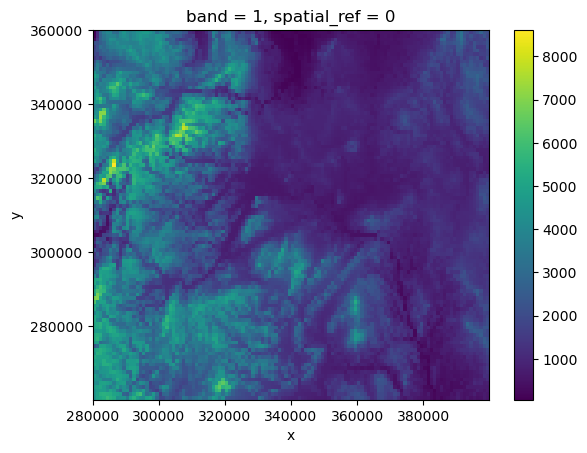

In [21]:
severn_hght.plot()

In [22]:
buildwas_hght = severn_hght.rio.clip(buildwas_shp.geometry.values, buildwas_shp.crs, drop=False, invert=False)

In [23]:
def make_region_hght_clip(region_shp, hght_data):
    region_clip = hght_data.rio.clip(region_shp.geometry.values, region_shp.crs, drop=False, invert=False)
    return region_clip

In [24]:
def coerse_data_into_haduk_format(one_day_data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    one_day_data = one_day_data.assign_coords(x=(one_day_data['x'] + offset))
    one_day_data = one_day_data.assign_coords(y=(one_day_data['y'] + offset))
    one_day_data = one_day_data.sel(x=xrange, y=yrange)
    one_day_data = one_day_data.rename({'x': 'projection_x_coordinate', 'y': 'projection_y_coordinate'})
    return one_day_data


In [25]:
def make_region_mask(region_data):
    """
    Make binary mask of clipped region data data
    """
    return (region_data/region_data.where(region_data>0))

In [26]:
severn_xrange = slice(280000, 399500)
severn_yrange = slice(260000, 359600)

In [27]:
buildwas_hght = make_region_hght_clip(buildwas_shp, hght_data=severn_hght)
buildwas_clip_fmt = coerse_data_into_haduk_format(buildwas_hght, offset=25, xrange=severn_xrange, yrange=severn_yrange)
buildwas_mask = make_region_mask(buildwas_clip_fmt)


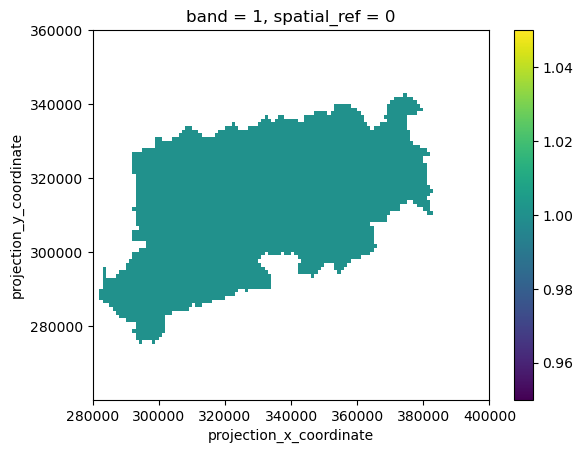

In [28]:
buildwas_mask.plot()

In [29]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * region_mask.data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    region_hght_mask_fmt = coerse_data_into_haduk_format(region_hght_mask, offset=25, xrange=severn_xrange, yrange=severn_yrange)
    return rainfall_data * region_hght_mask_fmt.data

def sum_region_rainfall(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.sum('time')
    return rainfall_data.sum()

def calc_prop_rainfall_over_region(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.groupby('time').apply(lambda row: row/row.sum())
    return rainfall_data/rainfall_data.sum()

In [30]:
haduk_severn_200803_mask = mask_region_rainfall(haduk_severn_200803['rainfall'], buildwas_mask)

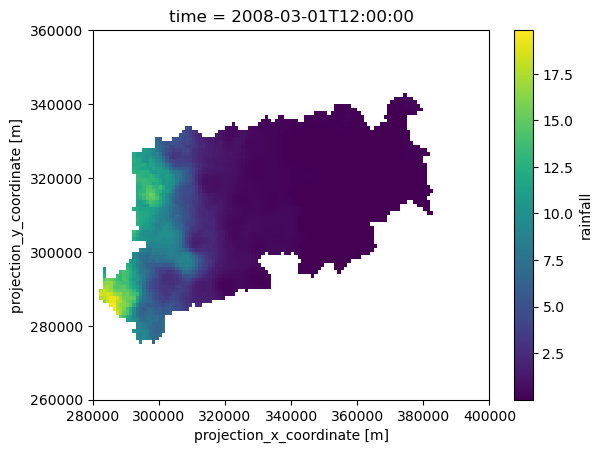

In [31]:
haduk_severn_200803_mask.isel(time=0).plot()

In [32]:
sum_region_rainfall(haduk_severn_200803_mask.isel(time=1))

<xarray.DataArray 'rainfall' ()> Size: 8B
array(5677.9796717)
Coordinates:
    time     datetime64[ns] 8B 2008-03-02T12:00:00

In [33]:
buildwas_hght = make_region_hght_clip(buildwas_shp, hght_data=severn_hght)
haduk_severn_200803_above_Plyn = mask_region_rainfall_by_hght(haduk_severn_200803['rainfall'], buildwas_hght, threshold=plynlimon_station['HGHT'].values[0])

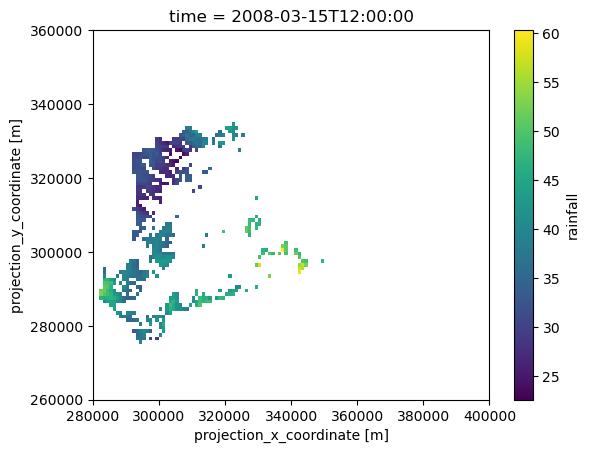

In [34]:
haduk_severn_200803_above_Plyn.isel(time=14).plot()

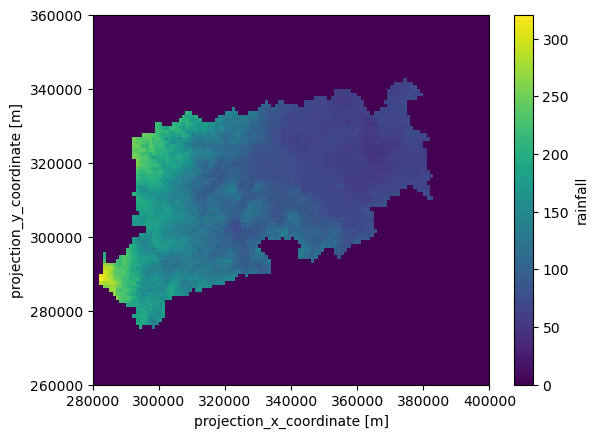

In [35]:
sum_region_rainfall(haduk_severn_200803_mask).plot()

In [36]:
haduk_severn_200803_mask_prop = calc_prop_rainfall_over_region(haduk_severn_200803_mask)

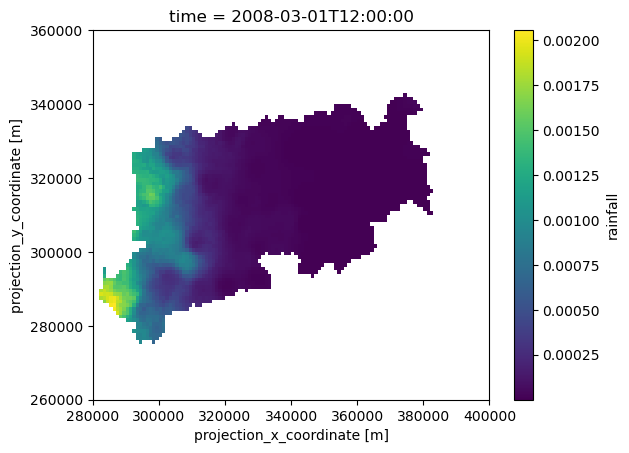

In [37]:
haduk_severn_200803_mask_prop.isel(time=0).plot()

In [38]:
haduk_severn_200803_mask_sum_prop = calc_prop_rainfall_over_region(sum_region_rainfall(haduk_severn_200803_mask))

1.0


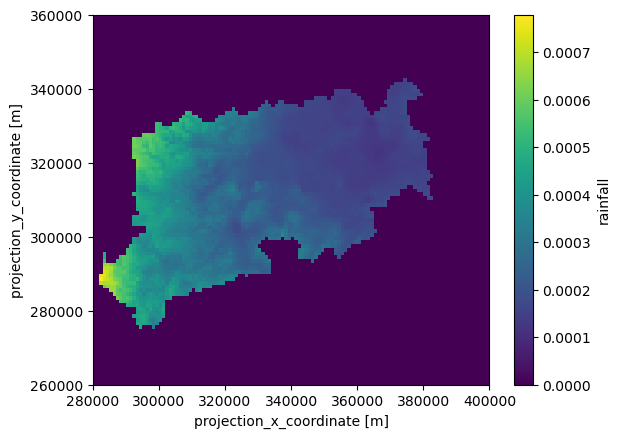

In [39]:
print(haduk_severn_200803_mask_sum_prop.sum().data)
haduk_severn_200803_mask_sum_prop.plot()

# Bringing it together

In [60]:
flood_data_dict.keys()

dict_keys(['flood200803', 'flood200811', 'flood201204', 'flood201302', 'flood202001'])

In [105]:
flood_to_examine = flood_data_dict["flood202001"]
flood_date = flood_to_examine["date"]
haduk_data = flood_to_examine["data"]
days_before_flood = 9 # 6 == 7 days before

In [106]:
def run_prop_rainfall_analysis(region_shp, flood_date, days_before_flood, haduk_data, hght_data):
    region_hght = make_region_hght_clip(region_shp, hght_data=hght_data)
    region_clip_fmt = coerse_data_into_haduk_format(region_hght, offset=25, xrange=severn_xrange, yrange=severn_yrange)
    region_mask = make_region_mask(region_clip_fmt)

    haduk_region_mask = mask_region_rainfall(haduk_data['rainfall'], region_mask)
    haduk_region_daysbefore_mask = haduk_region_mask.sel(time=slice((\
                                    flood_date-datetime.timedelta(days=days_before_flood)).strftime("%Y-%m-%d"),\
                                    flood_date.strftime("%Y-%m-%d")))
    haduk_region_mask_sum_prop = calc_prop_rainfall_over_region(sum_region_rainfall(haduk_region_daysbefore_mask))
    return haduk_region_mask_sum_prop

In [107]:
haduk_bewdley_mask_sum_prop = run_prop_rainfall_analysis(region_shp=bewdley_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=severn_hght)

In [108]:
haduk_abermule_mask_sum_prop = run_prop_rainfall_analysis(region_shp=abermule_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=severn_hght)

In [109]:
haduk_plynlimon_mask_sum_prop = run_prop_rainfall_analysis(region_shp=plynlimon_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=severn_hght)

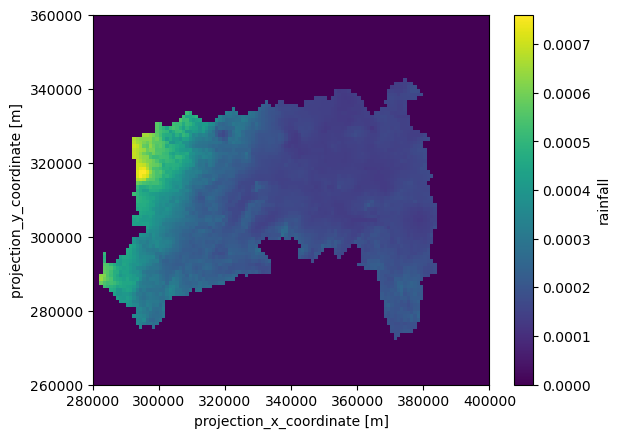

In [110]:
haduk_bewdley_mask_sum_prop.plot()

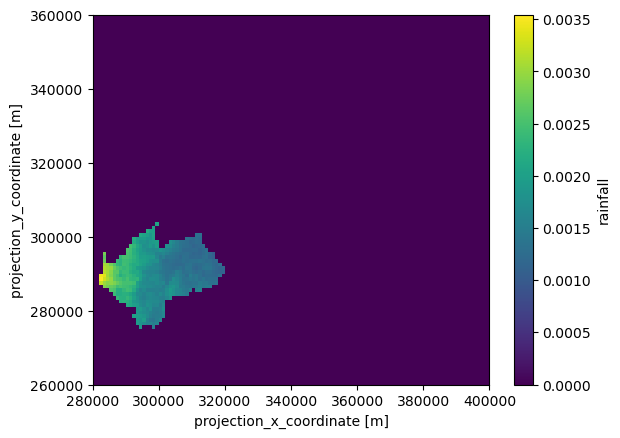

In [111]:
haduk_abermule_mask_sum_prop.plot()

(280000.0, 287500.0)

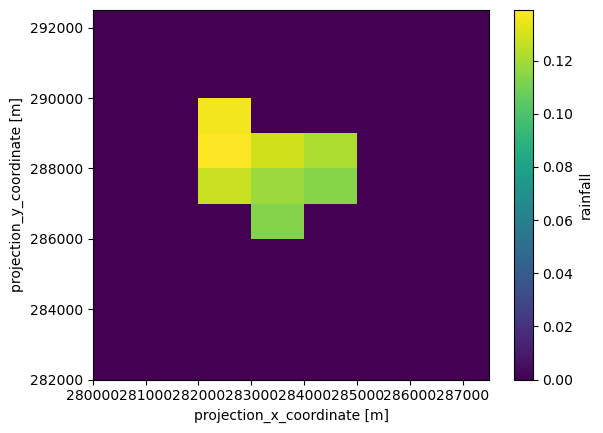

In [112]:
haduk_plynlimon_mask_sum_prop.plot()
plt.ylim(282000, 292500)
plt.xlim(280000, 287500)

### Now mask by height

In [113]:
height_buffer = 0 # add 50 metres
abermule_station_height = abermule_station['HGHT'].values[0]
dolwen_station_height = dolwen_station['HGHT'].values[0]
plynlimon_station_height = plynlimon_station['HGHT'].values[0]

abermule_station_height_buffer = abermule_station_height+height_buffer
dolwen_station_height_buffer = dolwen_station_height+height_buffer
plynlimon_station_height_buffer = plynlimon_station_height+height_buffer

In [114]:
bewdley_hght = make_region_hght_clip(bewdley_shp, hght_data=severn_hght)
haduk_bewdley_mask_sum_prop_above_abermule = mask_region_rainfall_by_hght(haduk_bewdley_mask_sum_prop, bewdley_hght, threshold=abermule_station_height_buffer)
haduk_bewdley_mask_sum_prop_above_dolwen = mask_region_rainfall_by_hght(haduk_bewdley_mask_sum_prop, bewdley_hght, threshold=dolwen_station_height_buffer)
haduk_bewdley_mask_sum_prop_above_plynlimon = mask_region_rainfall_by_hght(haduk_bewdley_mask_sum_prop, bewdley_hght, threshold=plynlimon_station_height_buffer)

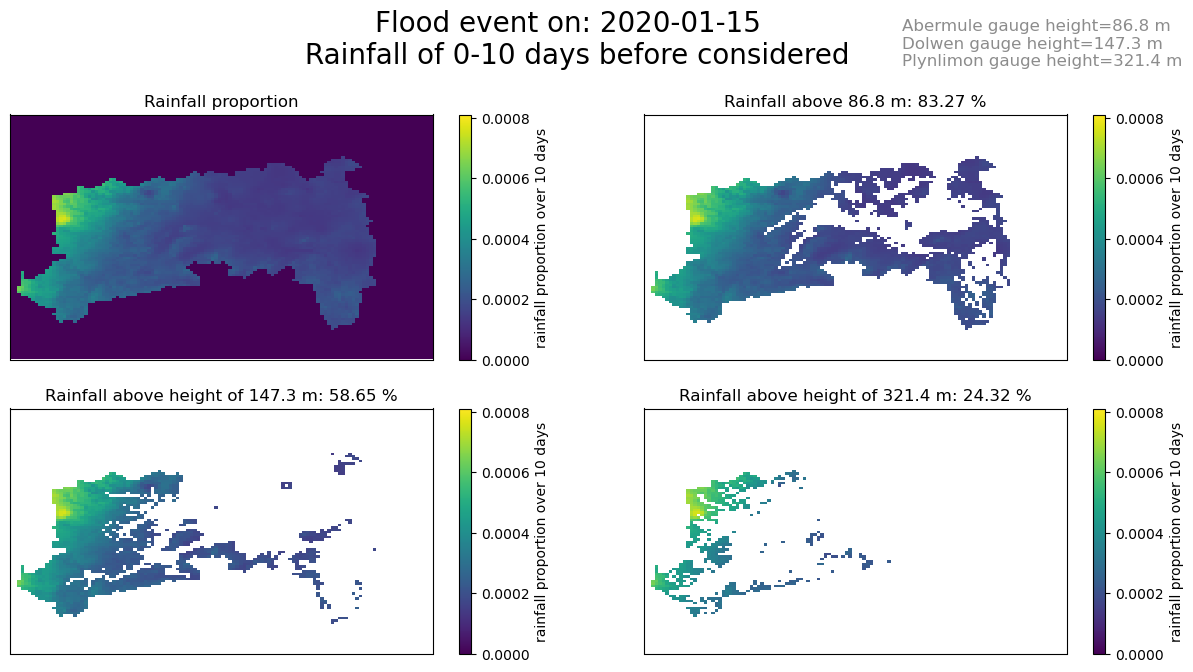

In [ ]:
pnt_above_abermule = (sum_region_rainfall(haduk_bewdley_mask_sum_prop_above_abermule)*100).data.round(2)
pnt_above_dolwen = (sum_region_rainfall(haduk_bewdley_mask_sum_prop_above_dolwen)*100).data.round(2)
pnt_above_plynlimon = (sum_region_rainfall(haduk_bewdley_mask_sum_prop_above_plynlimon)*100).data.round(2)
rain_prop_vmax = haduk_bewdley_mask_sum_prop.max().round(5)+0.00005

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
haduk_bewdley_mask_sum_prop.plot(ax=axes[0][0], vmin=0, vmax=rain_prop_vmax,\
                                 cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[0][0].set_title('Rainfall proportion');
haduk_bewdley_mask_sum_prop_above_abermule.plot(ax=axes[0][1], vmin=0, vmax=rain_prop_vmax,\
                                              cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[0][1].set_title(f'Rainfall above {abermule_station_height_buffer/10} m: {pnt_above_abermule} %');
haduk_bewdley_mask_sum_prop_above_dolwen.plot(ax=axes[1][0], vmin=0, vmax=rain_prop_vmax,\
                                                 cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[1][0].set_title(f'Rainfall above height of {dolwen_station_height_buffer/10} m: {pnt_above_dolwen} %');
haduk_bewdley_mask_sum_prop_above_plynlimon.plot(ax=axes[1][1], vmin=0, vmax=rain_prop_vmax,\
                                                 cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[1][1].set_title(f'Rainfall above height of {plynlimon_station_height_buffer/10} m: {pnt_above_plynlimon} %');
for ax in axes.flatten():
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([]); ax.set_yticks([]);
plt.suptitle(f'Flood event on: {flood_date.strftime("%Y-%m-%d")} \n Rainfall of 0-{days_before_flood+1} days before considered',\
              y=1.03, size=20)
fig.text(s=f'Abermule gauge height={abermule_station_height/10} m\nDolwen gauge height={dolwen_station_height/10} m\nPlynlimon gauge height={plynlimon_station_height/10} m',\
          x=.72, y=.95, color='grey', alpha=.9, size=12)

fig.subplots_adjust(hspace=.2)
# plt.savefig(f'figures/bewdley_{flood_date.strftime('%Y_%m_%d')}_{days_before_flood+1}d_prop_rain.png',\
#             bbox_inches='tight', dpi=200)

## Look at influence of height threshold

In [51]:
flood_to_examine = flood_data_dict["flood202001"]
days_before_flood = 9 # 9 == 10 days before

In [52]:
def calc_percentage_grid_cells_above_thresh(haduk_shp_mask_sum_prop, haduk_shp_mask_sum_prop_above_thresh):
    total_grid_cells = (haduk_shp_mask_sum_prop/haduk_shp_mask_sum_prop).sum()
    above_thresh_grid_cells = (haduk_shp_mask_sum_prop_above_thresh/haduk_shp_mask_sum_prop_above_thresh).sum()
    return ((above_thresh_grid_cells)/total_grid_cells)*100

Text(0.5, 1.0, 'River Severn - lead-up rainfall vs height')

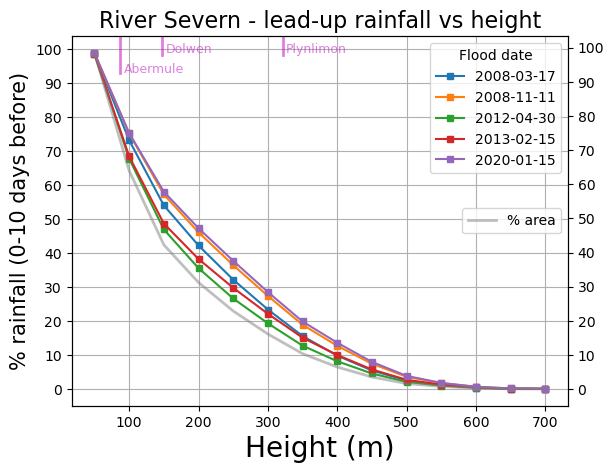

In [53]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]
    haduk_bewdley_mask_sum_prop = run_prop_rainfall_analysis(region_shp=bewdley_shp,\
                                                            flood_date=flood_date,\
                                                            days_before_flood=days_before_flood,\
                                                            haduk_data=haduk_data,\
                                                            hght_data=severn_hght)
    all_pnt_above_thresh = []
    all_num_cells = []
    height_thresholds = np.arange(500, bewdley_hght.max()+100, 500)
    for height_thresh in height_thresholds:
        haduk_bewdley_mask_sum_prop_above_thresh = mask_region_rainfall_by_hght(haduk_bewdley_mask_sum_prop, bewdley_hght, threshold=height_thresh)
        pnt_above_thresh = (sum_region_rainfall(haduk_bewdley_mask_sum_prop_above_thresh)*100).data.round(2)
        all_pnt_above_thresh.append(pnt_above_thresh)

        all_num_cells.append(calc_percentage_grid_cells_above_thresh(haduk_bewdley_mask_sum_prop, haduk_bewdley_mask_sum_prop_above_thresh))
    # Plot
    ax.plot(height_thresholds/10, all_pnt_above_thresh, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("Height (m)", size=20)
    ax.set_ylabel("% rainfall (0-10 days before)", size=15)
    ax.set_yticks(np.arange(0, 101, 10))
ax.axvline(x=abermule_station_height/10, ymin=.9, ymax=1, c='m', alpha=.5, linewidth=2)
# ax.axvline(x=abermule_station_height/10, ymin=0, ymax=1, c='m', alpha=.5, linewidth=1)
ax.axvline(x=dolwen_station_height/10, ymin=.95, ymax=1, c='m', alpha=.5, linewidth=2)
# ax.axvline(x=dolwen_station_height/10, ymin=0, ymax=1, c='m', alpha=.5, linewidth=1)
ax.axvline(x=plynlimon_station_height/10, ymin=.95, ymax=1, c='m', alpha=.5, linewidth=2)
# ax.axvline(x=plynlimon_station_height/10, ymin=0, ymax=1, c='m', alpha=.5, linewidth=1)

ax.text(s="Abermule", x=abermule_station_height/10+5, y=93, alpha=.5, size=9, c='m')
ax.text(s="Dolwen", x=dolwen_station_height/10+5, y=99, alpha=.5, size=9, c='m')
ax.text(s="Plynlimon", x=plynlimon_station_height/10+5, y=99, alpha=.5, size=9, c='m')

ax2 = ax.twinx()
ax2.plot(height_thresholds/10, all_num_cells, color='grey', linewidth=2, alpha=.5)
ax2.legend(["% area"], loc=5)
ax2.set_yticks(np.arange(0, 101, 10));
ax.set_title("River Severn - lead-up rainfall vs height", size=16)
# fig.savefig('figures/bewdley_all_floods_lineplot_threshold.png', bbox_inches='tight', dpi=300)

## Look at lead-up rainfall profile

In [54]:
num_lead_up_days = 15

Text(0.5, 1.0, 'River Severn - lead up days vs rain')

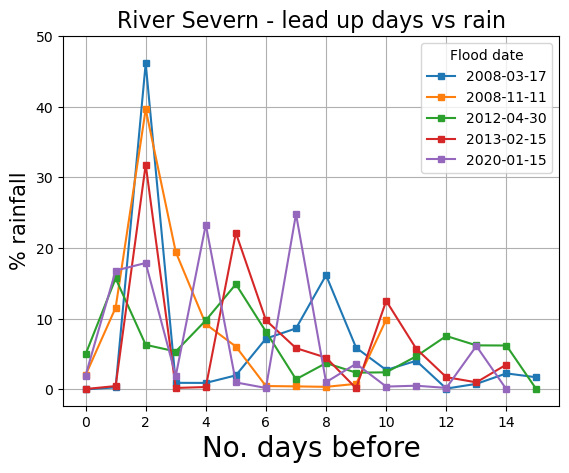

In [55]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(list(reversed(range(0, pnt_total_rain.data.shape[0]))), pnt_total_rain.data, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("% rainfall", size=15)
    ax.set_yticks(np.arange(0, 51, 10))

ax.set_title("River Severn - lead up days vs rain", size=16)
# fig.savefig('figures/severn_all_floods_leadupdays.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'River Severn - lead up days vs rain')

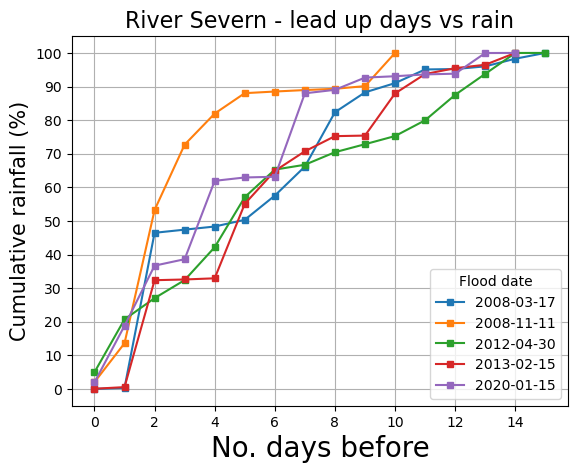

In [56]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(range(0, pnt_total_rain.data.shape[0]), np.cumsum(list(reversed(pnt_total_rain.data))), marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("Cumulative rainfall (%)", size=15)
    ax.set_yticks(np.arange(0, 101, 10))

ax.set_title("River Severn - lead up days vs rain", size=16)
# fig.savefig('figures/severn_all_floods_leadupdays_cumulative.png', bbox_inches='tight', dpi=300)